<a href="https://colab.research.google.com/github/zaki-m-khan/CSE337-ReinforcementLearning/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


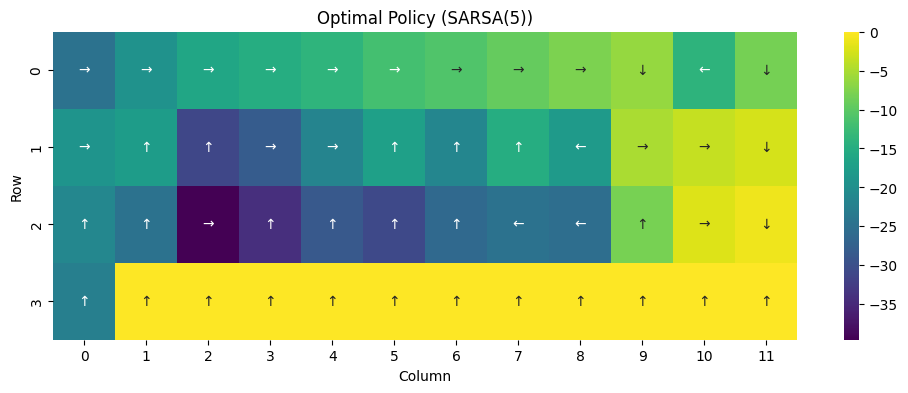

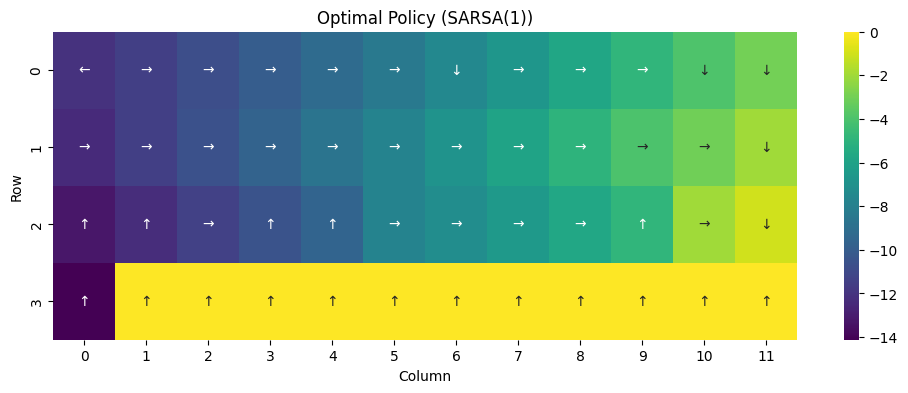

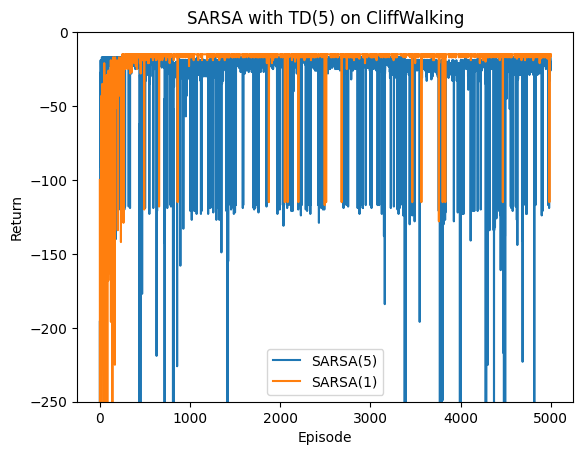

In [7]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns


def plot_policy(Q, title="SARSA"):
    # reshape q table to a 4x12 grid
    Q_grid = Q.reshape((4, 12, n_actions))

    # get the optimal action for each state and its corresponding q-value
    optimal_action = np.argmax(Q_grid, axis=2)
    optimal_policy_Q = np.max(Q_grid, axis=2)

    # define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
    action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)

    plt.figure(figsize=(12, 4))
    sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.title(f"Optimal Policy ({title})")  # <- tiny tweak so title arg is used
    plt.show()


# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = deque([state])
    actions = deque([action])
    rewards = deque()

    T = float("inf")
    t = 0

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            rewards.append(reward)
            states.append(next_state)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                actions.append(next_action)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            # accumulate discounted rewards
            for i in range(tau, min(tau + n_step, T)):
                G += (gamma ** (i - tau)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards))

Q_td5 = Q.copy()
returns_td5 = np.array(episode_returns)

#plot_policy(Q_td5, "Greedy Policy — SARSA(5)")

# sarsa from last weeks lab
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5000      # run same count for a fair overlay
max_steps = 100        # safety cap

# q / sarsa params (mine from last week)
learning_rate = 0.1
discount_factor = 0.99
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))

sarsaRewards = np.zeros(n_episodes)

'''
mine from last week:
start with q-table = zeros.
for each episode: reset env, pick first action with e greedy.
loop until done:
   take action -> get next state + reward.
   pick next action with e greedy
   update q[s,a] with sarsa eq. 6.9
   move to next state/action.
decay e after each episode.
'''

# e greedy: sometimes explore, otherwise take the best action we know (mine from last week)
def choose_action(state, eps):
    if np.random.rand() < eps:                 # explore
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))            # exploit

# simple hyperparams (mine from last week)
alpha = learning_rate          # step size
gamma = discount_factor        # discount
epsilon = 0.10                 # 10% exploration
eps_min = 0.01                 # never stop exploring completely
eps_decay = 0.995              # get a bit greedier each episode

for episode in range(n_episodes):
    state, _ = env.reset()
    action = choose_action(state, epsilon)     # first action (on-policy)
    total_reward = 0

    for step_i in range(max_steps):
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # on-policy target: use the action we will actually take next (mine from last week)
        if not done:
            next_action = choose_action(next_state, epsilon)
            target = reward + gamma * Q[next_state, next_action]
        else:
            next_action = None
            target = reward

        # sarsa update from textbook (eq. 6.9) (mine from last week)
        Q[state, action] += alpha * (target - Q[state, action])

        # move on
        state = next_state
        if next_action is not None:
            action = next_action
        if done:
            break

    sarsaRewards[episode] = total_reward
    # decay e each episode (mine from last week)
    epsilon = max(eps_min, epsilon * eps_decay)

Q_sarsa1 = Q.copy()
env.close()
plot_policy(Q_td5, "SARSA(5)")
plot_policy(Q_sarsa1, "SARSA(1)")
plt.plot(returns_td5)
plt.plot(sarsaRewards)
plt.legend(["SARSA(5)", "SARSA(1)"])
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title(f"SARSA with TD({n_step}) on CliffWalking")
plt.ylim([-250, 0]); plt.show()


SARSA(5) looks further ahead when updating values, while standard SARSA(1) only looks one step ahead. In CliffWalking, this means SARSA(1) usually learns a safe path a bit quicker, especially when exploration gets smaller over time. SARSA(5) spreads information faster through the Q-table, but if exploration stays high it keeps stepping into the cliff and shows more ups and downs in rewards. Overall, SARSA(1) ends up with steadier learning, while SARSA(5) can be a bit noisier but sometimes captures longer-term effects better.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Starting Dyna-Q with N = 5


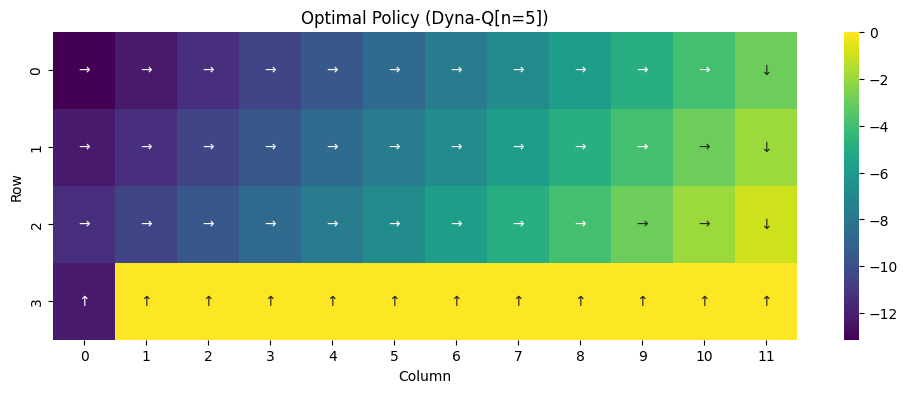

Part C — 2: Dyna-Q with n=5 surpassed threshold (-30) at Episode: 103
Starting Dyna-Q with N = 20


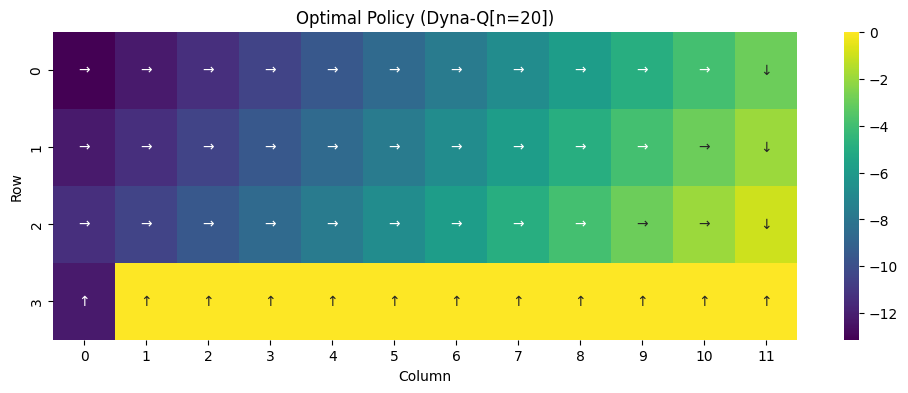

Part C — 2: Dyna-Q with n=20 surpassed threshold (-30) at Episode: 130
Starting Dyna-Q with N = 50


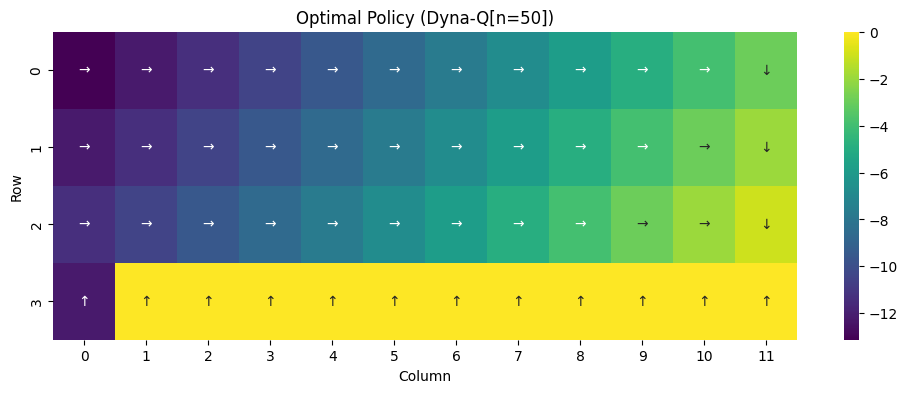

Part C — 2: Dyna-Q with n=50 surpassed threshold (-30) at Episode: 101


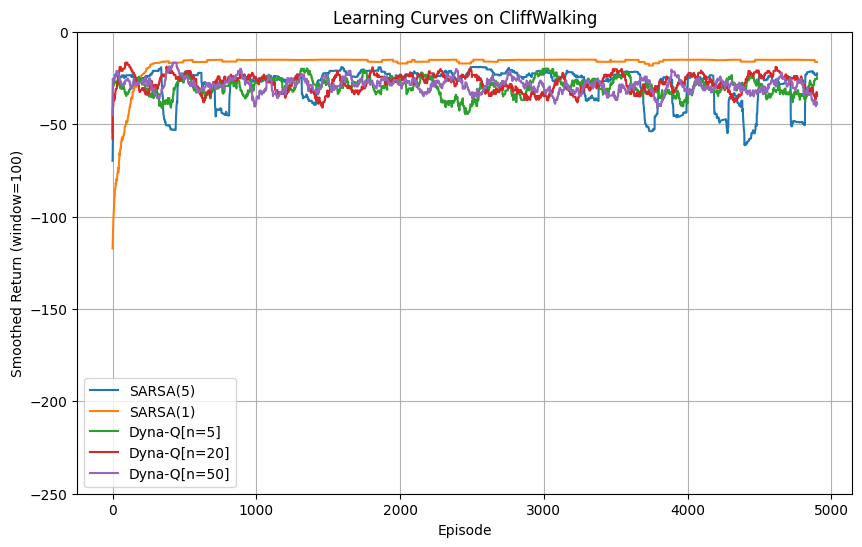

In [9]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns

def plot_policy(Q, title="policy"):
    n_actions = 4
    Q_grid = Q.reshape((4, 12, n_actions))
    optimal_action = np.argmax(Q_grid, axis=2)
    optimal_policy_Q = np.max(Q_grid, axis=2)
    action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)

    plt.figure(figsize=(12, 4))
    sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True)
    plt.xlabel("Column"); plt.ylabel("Row")
    plt.title(f"Optimal Policy ({title})")
    plt.show()


# Part A — Dyna-Q (Implementation)
env = gym.make("CliffWalking-v1")
n_states = env.observation_space.n
n_actions = env.action_space.n

alpha   = 0.1
gamma   = 0.99
epsilon = 0.05
n_episodes = 5000
n_list = [5, 20, 50]   # planning steps N
window_size = 100
threshold = -30

def e_greedy(Q, s):
    #e-greedy exploration
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[s]))

def run_dyna_q(N):
    #q-table
    Q = np.zeros((n_states, n_actions))
    #model: dictionary of most-recent outcome per (s,a)
    model = {}                        # (s,a) -> (r, s')
    seen_pairs = []                   # list of previously seen (s,a) for sampling
    returns = []

    for ep in range(n_episodes):
        s, _ = env.reset()
        total = 0
        while True:
            a = e_greedy(Q, s)
            s2, r, terminated, truncated, _ = env.step(a)
            total += r
            done = terminated or truncated

            #real update: Q-learning backup after each env step
            Q[s, a] += alpha * ((r + (0 if done else gamma * np.max(Q[s2]))) - Q[s, a])

            #update the model from the observed transition
            if (s, a) not in model:
                seen_pairs.append((s, a))
            model[(s, a)] = (r, s2)

            #planning: N simulated updates sampled from model
            for _ in range(N):
                sp, ap = seen_pairs[np.random.randint(len(seen_pairs))]
                rp, sp2 = model[(sp, ap)]
                Q[sp, ap] += alpha * ((rp + gamma * np.max(Q[sp2])) - Q[sp, ap])

            s = s2
            if done:
                break

        returns.append(total)
    return Q, np.array(returns)

# run dyna-q for N in {5,20,50}
dyna = {}
for N in n_list:
    print("Starting Dyna-Q with N =", N)
    QN, R = run_dyna_q(N)
    dyna[N] = {"Q": QN, "returns": R}
    plot_policy(QN, f"Dyna-Q[n={N}]")
    # used chatgpt to help smooth the results, sample efficiency threshold (moving average > −30)
    smooth = np.convolve(R, np.ones(window_size)/window_size, mode="valid")
    first_ok = next((i for i, v in enumerate(smooth) if v > threshold), -1)
    if first_ok != -1:
        first_ok += window_size - 1
    print(f"Part C — 2: Dyna-Q with n={N} surpassed threshold ({threshold}) at Episode: {first_ok}")


# Part B — Baselines (Re-use / Implement)

def movavg(x, w=100):
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode="valid")


# Part C — Experiments & Comparisons
plt.figure(figsize=(10,6))
# baseline
try:
    plt.plot(movavg(returns_td5, window_size), label="SARSA(5)")
except NameError:
    pass
try:
    plt.plot(movavg(sarsaRewards, window_size), label="SARSA(1)")
except NameError:
    pass

# dyna-q curves
for N in n_list:
    plt.plot(movavg(dyna[N]["returns"], window_size), label=f"Dyna-Q[n={N}]")

plt.xlabel("Episode")
plt.ylabel(f"Smoothed Return (window={window_size})")
plt.title("Learning Curves on CliffWalking")
plt.ylim([-250, 0])
plt.legend()
plt.grid(True)
plt.show()



## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
